In [1]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
train = pd.read_csv('/home/jwjung/Recsys/ml-100k/ml-100k/ua.base'
,sep = '\t', names = ['user','movie','rating','ts'])
test = pd.read_csv('/home/jwjung/Recsys/ml-100k/ml-100k/ua.test'
,sep = '\t', names = ['user','movie','rating','ts'])

train.head()

,user,movie,rating,ts
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [5]:
items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])

In [7]:
items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

In [9]:
latent_dim = 100

num_items = items.max() + 1
num_users = users.max() + 1

torch.manual_seed(23)

P = torch.randn(num_items, latent_dim, requires_grad = True)
Q = torch.randn(num_users, latent_dim, requires_grad = True)

optimizer = torch.optim.Adam([P,Q], lr = 0.1)

# P = P.to(device)
# Q = Q.to(device)

for epoch in range(1000):
    """
    1. P[items]는 P에서 해당하는 item의 벡터만 따로 뽑아오는 의미
    P가 하나의 look-up table로서 작용

    2. torch.sum에서 dim 없으면 전체 원소 합 도출
    -> dim = 1은 2차원 기준으로 row 단위로 합 구하라는 의미
    -> 여기서 dim = 1로 sum 하는 이유: 각 벡터의 feature 별 elementwise product 값이 도출된 결과가
    rating matrix의 하나의 element로 존재 -> 그 값을 전부 더해줘야 하나의 rating 도출 가능
    ex) feature dim = 3일 때 P*Q 결과: [-1,2,2] => 각 feature 별 점수 합친 3이 pred_rating 임!!

    3. P * Q 는 elementwise product -> dot product 아님!!! (dot product는 torch.matmul 사용)
    """
    hypothesis = torch.sum(P[items] * Q[users],dim = 1)
    cost = F.mse_loss(hypothesis, ratings)

    optimizer.zero_grad() # zero_grad 처리 안해줄 시, 이전 epoch에서 구한 grad값이 남아있어서 값이 더해짐! -> 그 값날린다 생각 (초기화)
    cost.backward() # backpropagation 진행
    optimizer.step() # backprop 진행 시 나온 변화도로 parameter 조정

    if epoch % 100 == 0:
        print(f"epoch: {epoch}, cost: {cost.item()}")

epoch: 0, cost: 113.22349548339844
epoch: 100, cost: 0.07415642589330673
epoch: 200, cost: 0.02603706531226635
epoch: 300, cost: 0.012116883881390095
epoch: 400, cost: 0.006513094529509544
epoch: 500, cost: 0.0038396616000682116
epoch: 600, cost: 0.0024231839925050735
epoch: 700, cost: 0.0015664342790842056
epoch: 800, cost: 0.0010517718037590384
epoch: 900, cost: 0.0007269495399668813


epoch: 0, cost: 3.773289918899536
epoch: 100, cost: 0.0004792663094121963
epoch: 200, cost: 6.285190465860069e-05
epoch: 300, cost: 1.6005731595214456e-05
epoch: 400, cost: 1.5689463907619938e-05
epoch: 500, cost: 2.3776483430992812e-05
epoch: 600, cost: 1.382586924592033e-05
epoch: 700, cost: 2.9950553653179668e-05
epoch: 800, cost: 3.708141593961045e-05
epoch: 900, cost: 2.3223290554597043e-05


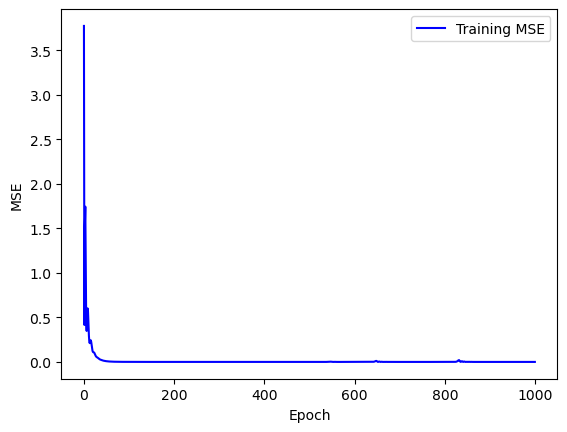

In [12]:
optimizer = torch.optim.Adam([P, Q], lr= 0.1)

X = []
Y = []

for epoch in range(1000):

    hypothesis = torch.sum(P[items] * Q[users], dim= 1)
    cost = F.mse_loss(hypothesis ,ratings)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    X.append(epoch)
    Y.append(cost.item())

    if epoch % 100 == 0:
        print(f"epoch: {epoch}, cost: {cost.item()}")

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.legend()
plt.show()

### Evaluation

epoch: 0, cost: 97.34024047851562
epoch: 100, cost: 23.13702392578125
epoch: 200, cost: 24.422210693359375
epoch: 300, cost: 25.24277114868164
epoch: 400, cost: 25.815757751464844
epoch: 500, cost: 26.21258544921875
epoch: 600, cost: 26.496997833251953
epoch: 700, cost: 26.70473289489746
epoch: 800, cost: 26.854867935180664
epoch: 900, cost: 26.959928512573242


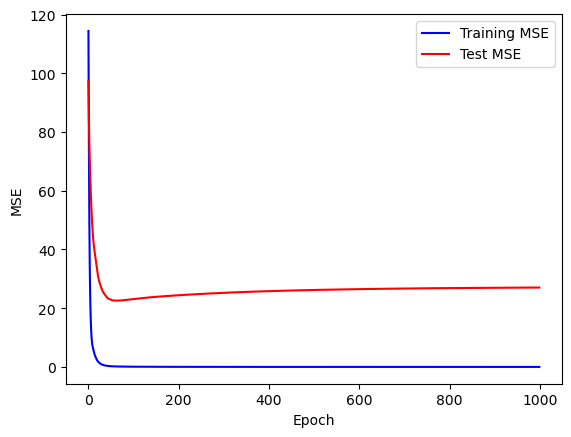

In [14]:
latent_dim = 100

num_items = items.max() + 1
num_users = users.max() + 1

torch.manual_seed(20)

P = torch.randn(num_items, latent_dim, requires_grad = True)
Q = torch.randn(num_users, latent_dim, requires_grad = True)

optimizer = torch.optim.Adam([P,Q], lr = 0.1)

X = []
Y = []
Y_test = []

for epoch in range(1000):

    hypothesis = torch.sum(P[items] * Q[users], dim= 1)
    cost = F.mse_loss(hypothesis ,ratings)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 기울기 계산 필요 없다.
    with torch.no_grad():
        # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교.
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
        cost_test = F.mse_loss(hypo_test, ratings_test)

        X.append(epoch)
        Y.append(cost.item())
        Y_test.append(cost_test.item())

    if epoch % 100 == 0:
        print(f"epoch: {epoch}, cost: {cost_test.item()}")

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

### MF by GPU

In [24]:
items_gpu = torch.cuda.LongTensor(train['movie'])
users_gpu = torch.cuda.LongTensor(train['user'])
ratings_gpu = torch.cuda.FloatTensor(train['rating'])

items_test_gpu = torch.cuda.LongTensor(test['movie'])
users_test_gpu = torch.cuda.LongTensor(test['user'])
ratings_test_gpu = torch.cuda.FloatTensor(test['rating'])

epoch: 0, cost: 528.2863159179688
epoch: 100, cost: 0.0019956617616117
epoch: 200, cost: 6.43480362327864e-08
epoch: 300, cost: 9.286424028687179e-05
epoch: 400, cost: 0.0003572636633180082
epoch: 500, cost: 0.0024175920989364386
epoch: 600, cost: 0.0039963023737072945
epoch: 700, cost: 0.004064539447426796
epoch: 800, cost: 0.003977971151471138
epoch: 900, cost: 0.006441423669457436


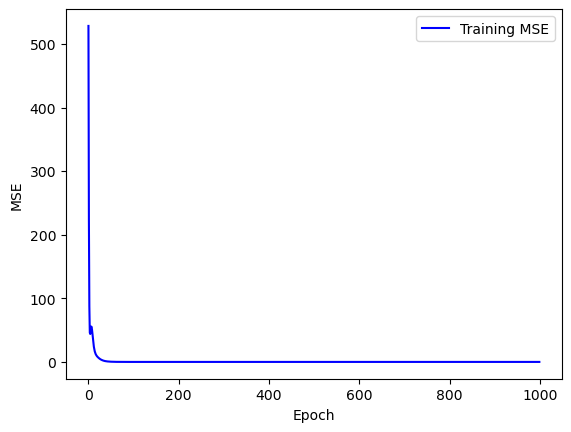

In [37]:
latent_dim = 512

num_items_gpu = items_gpu.max() + 1
num_users_gpu = users_gpu.max() + 1

torch.manual_seed(18)

P_gpu = torch.randn(num_items_gpu, latent_dim, requires_grad = True, device = 'cuda:0')
Q_gpu = torch.randn(num_users_gpu, latent_dim, requires_grad = True, device = 'cuda:0')


optimizer = torch.optim.Adam([P_gpu,Q_gpu], lr = 0.1)

P_gpu = P_gpu.to(device)
Q_gpu = Q_gpu.to(device)

X = []
Y = []

for epoch in range(1000):
    hypothesis_gpu = torch.sum(P_gpu[items_gpu] * Q_gpu[users_gpu],dim = 1)
    cost = F.mse_loss(hypothesis_gpu, ratings_gpu)

    optimizer.zero_grad()
    cost.backward() 
    optimizer.step() 

    X.append(epoch)
    Y.append(cost.item())   

    if epoch % 100 == 0:
        print(f"epoch: {epoch}, cost: {cost.item()}")

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.legend()
plt.show()

epoch: 0, cost: 478.6468505859375
epoch: 100, cost: 204.5281219482422
epoch: 200, cost: 204.44227600097656
epoch: 300, cost: 204.433837890625
epoch: 400, cost: 204.30523681640625
epoch: 500, cost: 204.0463409423828
epoch: 600, cost: 203.54644775390625
epoch: 700, cost: 202.708984375
epoch: 800, cost: 201.54368591308594
epoch: 900, cost: 199.9500274658203


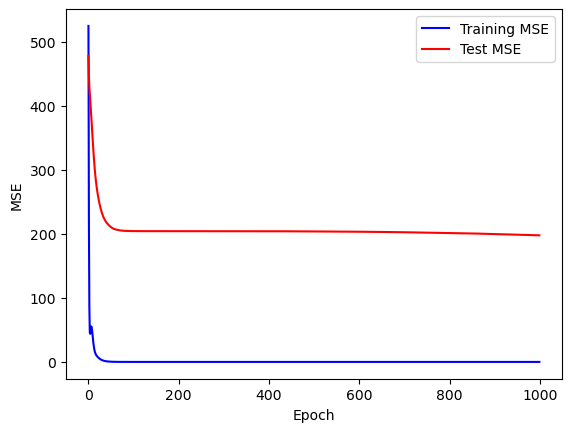

In [40]:
latent_dim = 512

num_items = items_gpu.max() + 1
num_users = users_gpu.max() + 1

torch.manual_seed(20)

P_gpu = torch.randn(num_items_gpu, latent_dim, requires_grad = True, device = 'cuda:0')
Q_gpu = torch.randn(num_users_gpu, latent_dim, requires_grad = True, device = 'cuda:0')

optimizer = torch.optim.Adam([P_gpu,Q_gpu], lr = 0.1)

P_gpu.to(device)
Q_gpu.to(device)

X = []
Y = []
Y_test = []

for epoch in range(1000):

    hypothesis_gpu = torch.sum(P_gpu[items_gpu] * Q_gpu[users_gpu], dim= 1)
    cost = F.mse_loss(hypothesis_gpu ,ratings_gpu)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 기울기 계산 필요 없다.
    with torch.no_grad():
        # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교.
        hypo_test_gpu = torch.sum(P_gpu[items_test_gpu] * Q_gpu[users_test_gpu], dim=1)
        cost_test = F.mse_loss(hypo_test_gpu, ratings_test_gpu)

        X.append(epoch)
        Y.append(cost.item())
        Y_test.append(cost_test.item())

    if epoch % 100 == 0:
        print(f"epoch: {epoch}, cost: {cost_test.item()}")

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

### Regulation 추가

epoch: 0, cost: 528.2863159179688
epoch: 100, cost: 13.684283256530762
epoch: 200, cost: 13.685381889343262
epoch: 300, cost: 13.685381889343262
epoch: 400, cost: 13.685381889343262
epoch: 500, cost: 13.685381889343262
epoch: 600, cost: 13.685381889343262
epoch: 700, cost: 13.685381889343262
epoch: 800, cost: 13.685381889343262
epoch: 900, cost: 13.685381889343262


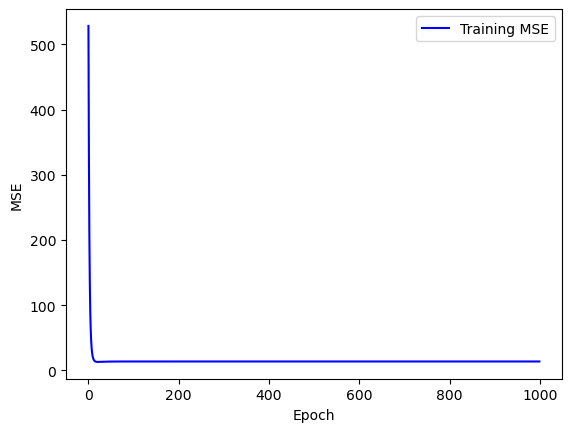

In [42]:
latent_dim = 512

lambda1 = 0.01

num_items_gpu = items_gpu.max() + 1
num_users_gpu = users_gpu.max() + 1

torch.manual_seed(18)

P_gpu = torch.randn(num_items_gpu, latent_dim, requires_grad = True, device = 'cuda:0')
Q_gpu = torch.randn(num_users_gpu, latent_dim, requires_grad = True, device = 'cuda:0')

optimizer = torch.optim.Adam([P_gpu,Q_gpu], lr = 0.1)

P_gpu = P_gpu.to(device)
Q_gpu = Q_gpu.to(device)

X = []
Y = []

for epoch in range(1000):
    hypothesis_gpu = torch.sum(P_gpu[items_gpu] * Q_gpu[users_gpu],dim = 1)
    cost = F.mse_loss(hypothesis_gpu, ratings_gpu)
    loss = cost + lambda1*torch.sum(P_gpu**2) + lambda1*torch.sum(Q_gpu**2) 

    optimizer.zero_grad()
    loss.backward() 
    optimizer.step() 

    X.append(epoch)
    Y.append(cost.item())   

    if epoch % 100 == 0:
        print(f"epoch: {epoch}, cost: {cost.item()}")

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.legend()
plt.show()

epoch: 0, cost: 478.6468505859375
epoch: 100, cost: 204.5281219482422
epoch: 200, cost: 204.44227600097656
epoch: 300, cost: 204.433837890625
epoch: 400, cost: 204.30523681640625
epoch: 500, cost: 204.0463409423828
epoch: 600, cost: 203.54644775390625
epoch: 700, cost: 202.708984375
epoch: 800, cost: 201.54368591308594
epoch: 900, cost: 199.9500274658203
epoch: 1000, cost: 197.9168701171875
epoch: 1100, cost: 195.48199462890625
epoch: 1200, cost: 192.67044067382812
epoch: 1300, cost: 189.32830810546875
epoch: 1400, cost: 185.7309112548828
epoch: 1500, cost: 181.60885620117188
epoch: 1600, cost: 177.28546142578125
epoch: 1700, cost: 172.7411346435547
epoch: 1800, cost: 167.8766632080078
epoch: 1900, cost: 162.99603271484375
epoch: 2000, cost: 157.81800842285156
epoch: 2100, cost: 152.50425720214844
epoch: 2200, cost: 147.36669921875
epoch: 2300, cost: 141.99591064453125
epoch: 2400, cost: 136.61563110351562
epoch: 2500, cost: 131.6019287109375
epoch: 2600, cost: 126.36647033691406
epoch

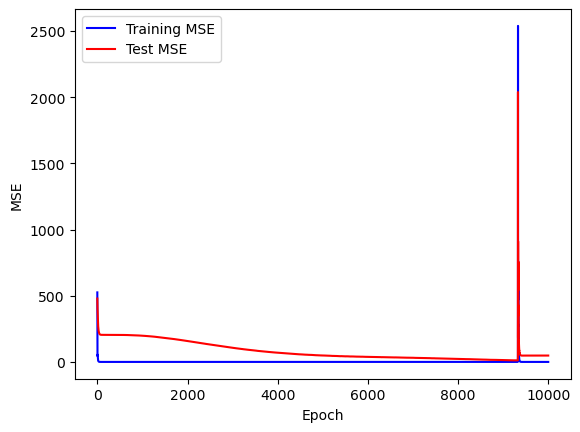

In [60]:
latent_dim = 512

num_items = items_gpu.max() + 1
num_users = users_gpu.max() + 1

torch.manual_seed(20)

P_gpu = torch.randn(num_items_gpu, latent_dim, requires_grad = True, device = 'cuda:0')
Q_gpu = torch.randn(num_users_gpu, latent_dim, requires_grad = True, device = 'cuda:0')

optimizer = torch.optim.Adam([P_gpu,Q_gpu], lr = 0.1)

P_gpu.to(device)
Q_gpu.to(device)

X = []
Y = []
Y_test = []

for epoch in range(10000):

    hypothesis_gpu = torch.sum(P_gpu[items_gpu] * Q_gpu[users_gpu], dim= 1)
    cost = F.mse_loss(hypothesis_gpu ,ratings_gpu)
    loss = cost + lambda1*torch.sum(P_gpu**2) + lambda1*torch.sum(Q_gpu**2) 

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 기울기 계산 필요 없다.
    with torch.no_grad():
        # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교.
        hypo_test_gpu = torch.sum(P_gpu[items_test_gpu] * Q_gpu[users_test_gpu], dim=1)
        cost_test = F.mse_loss(hypo_test_gpu, ratings_test_gpu)

        X.append(epoch)
        Y.append(cost.item())
        Y_test.append(cost_test.item())

    if epoch % 100 == 0:
        print(f"epoch: {epoch}, cost: {cost_test.item()}")

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

In [58]:
lambda1*torch.sum(P_gpu**2) 

tensor(7315.6748, device='cuda:0', grad_fn=<MulBackward0>)

epoch: 0, cost: 517.3966064453125


epoch: 100, cost: 1.2679747343063354
epoch: 200, cost: 1.2680259943008423
epoch: 300, cost: 1.2680259943008423
epoch: 400, cost: 1.2680259943008423
epoch: 500, cost: 1.2680259943008423
epoch: 600, cost: 1.2680259943008423
epoch: 700, cost: 1.2680259943008423
epoch: 800, cost: 1.2680259943008423
epoch: 900, cost: 1.2680259943008423


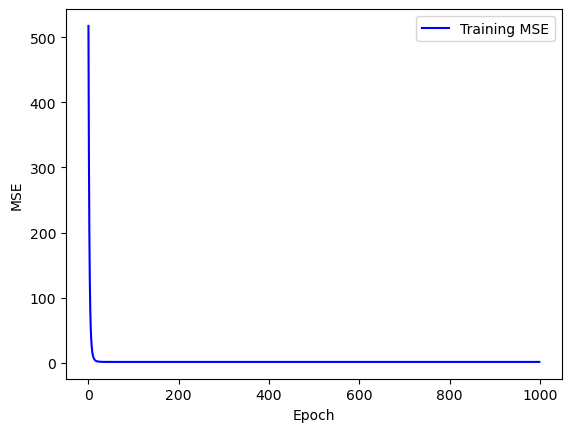

In [61]:
latent_dim = 512

lambda1 = 0.01

num_items_gpu = items_gpu.max() + 1
num_users_gpu = users_gpu.max() + 1

torch.manual_seed(15)

P_gpu = torch.randn(num_items_gpu, latent_dim, requires_grad = True, device = 'cuda:0')
Q_gpu = torch.randn(num_users_gpu, latent_dim, requires_grad = True, device = 'cuda:0')

bias_item = torch.randn(num_items_gpu, requires_grad = True, device = 'cuda:0')
bias_user = torch.randn(num_users_gpu, requires_grad = True, device = 'cuda:0')

overall_mean = (ratings_gpu.sum() / len(ratings_gpu)).item()

optimizer = torch.optim.Adam([P_gpu,Q_gpu], lr = 0.1)

P_gpu = P_gpu.to(device)
Q_gpu = Q_gpu.to(device)

X = []
Y = []

for epoch in range(1000):
    hypothesis_gpu = torch.sum(P_gpu[items_gpu] * Q_gpu[users_gpu],dim = 1) + overall_mean 
    + bias_item[items_gpu] + bias_user[users_gpu]
    
    cost = F.mse_loss(hypothesis_gpu, ratings_gpu)
    
    loss = cost + lambda1*torch.sum(P_gpu**2) + lambda1*torch.sum(Q_gpu**2) 
    + lambda1*torch.sum(bias_item ** 2) + lambda1*torch.sum(bias_user ** 2)

    optimizer.zero_grad()
    loss.backward() 
    optimizer.step() 

    X.append(epoch)
    Y.append(cost.item())   

    if epoch % 100 == 0:
        print(f"epoch: {epoch}, cost: {cost.item()}")

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.legend()
plt.show()

epoch: 0, cost: 477.91259765625
epoch: 100, cost: 197.83961486816406
epoch: 200, cost: 197.7562713623047
epoch: 300, cost: 197.73655700683594
epoch: 400, cost: 197.63119506835938
epoch: 500, cost: 197.36285400390625
epoch: 600, cost: 196.81463623046875
epoch: 700, cost: 195.95045471191406
epoch: 800, cost: 194.8154296875
epoch: 900, cost: 193.18943786621094
epoch: 1000, cost: 191.2528076171875
epoch: 1100, cost: 188.79736328125
epoch: 1200, cost: 185.98081970214844
epoch: 1300, cost: 182.82887268066406
epoch: 1400, cost: 179.16458129882812
epoch: 1500, cost: 175.26065063476562
epoch: 1600, cost: 171.0150604248047
epoch: 1700, cost: 166.65707397460938
epoch: 1800, cost: 161.9780731201172
epoch: 1900, cost: 157.225341796875
epoch: 2000, cost: 152.27694702148438
epoch: 2100, cost: 147.36428833007812
epoch: 2200, cost: 142.1318359375
epoch: 2300, cost: 137.316162109375
epoch: 2400, cost: 132.11798095703125
epoch: 2500, cost: 127.2649917602539
epoch: 2600, cost: 122.30921936035156
epoch: 27

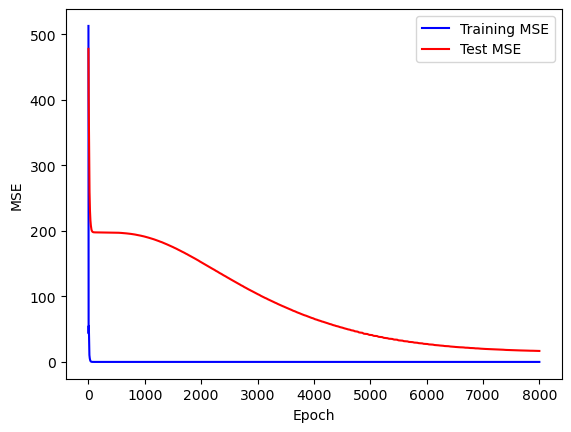

In [63]:
latent_dim = 512

num_items = items_gpu.max() + 1
num_users = users_gpu.max() + 1

torch.manual_seed(20)

P_gpu = torch.randn(num_items_gpu, latent_dim, requires_grad = True, device = 'cuda:0')
Q_gpu = torch.randn(num_users_gpu, latent_dim, requires_grad = True, device = 'cuda:0')

optimizer = torch.optim.Adam([P_gpu,Q_gpu], lr = 0.1)

P_gpu.to(device)
Q_gpu.to(device)

X = []
Y = []
Y_test = []

for epoch in range(8000):

    hypothesis_gpu = torch.sum(P_gpu[items_gpu] * Q_gpu[users_gpu],dim = 1) + overall_mean 
    + bias_item[items_gpu] + bias_user[users_gpu]

    cost = F.mse_loss(hypothesis_gpu ,ratings_gpu)
    loss = cost + lambda1*torch.sum(P_gpu**2) + lambda1*torch.sum(Q_gpu**2) 
    + lambda1*torch.sum(bias_item ** 2) + lambda1*torch.sum(bias_user ** 2) 

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 기울기 계산 필요 없다.
    with torch.no_grad():
        # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교.
        hypo_test_gpu = torch.sum(P_gpu[items_test_gpu] * Q_gpu[users_test_gpu], dim=1)
        cost_test = F.mse_loss(hypo_test_gpu, ratings_test_gpu)

        X.append(epoch)
        Y.append(cost.item())
        Y_test.append(cost_test.item())

    if epoch % 100 == 0:
        print(f"epoch: {epoch}, cost: {cost_test.item()}")

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()